# Formación de un agente DQN en el juego de Conecta Cuatro

**Autor**: [albertobas](https://www.github.com/albertobas)<br />**Fecha de creación**: 11/10/2023<br />**Descripción**: ejercicio para obtener una estrategia, plan o política de acción (policy) que sea capaz de maximizar esta recompensa, obteniendo así la mejor acción para cada transición y propiciando una aproximación óptima al juego de Conecta Cuatro.

<a href="https://colab.research.google.com/github/albertobas/zk-connect-four/blob/main/apps/web/model/conecta_cuatro.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir en Colab"/></a>
<br />

---

## Introducción

Durante el desarrollo de una aplicación de conocimiento cero llamada [zk Connect Four](https://www.albertobas.com/es/blog/how-to-build-zero-knowledge-dapp "Cómo desarrollar una DApp de conocimiento cero") se dio el contexto adecuado para la implementación de un agente de aprendizaje por refuerzo.

El aprendizaje por refuerzo es un paradigma de aprendizaje automático en el que un agente aprende de su entorno a través de prueba y error. Es decir, se trata de una aproximación computacional al aprendizaje a partir de acciones.

El objetivo es aprender cuáles son las acciones más adecuadas en cada estado del juego para maximizar una recompensa. Para ello, en este cuaderno se implementan un agente de aprendizaje profundo Q (DQN) y un agente de aprendizaje profundo Q doble (DDQN) para optimizar un aproximador en el juego Conecta Cuatro utilizando [PyTorch](https://www.albertobas.com/es/tags/pytorch "PyTorch").

## Configuración


In [1]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
from constants import CHECKPOINTS_DIR_PATH, FIGURES_DIR_PATH, POLICIES_DIR_PATH, finishes_boards_solutions, blocks_boards_solutions
from custom_types import ParamsAgent, ParamsEnv, ParamsEval, ParamsTrain
from env import ConnectFourEnv
from modules import Module
from os.path import join
from pathlib import Path
from replay import ExperienceReplay, Transition
from training import export_onnx, plot, train
from typing import List, Literal
from utils import get_html, get_two_channels
from IPython.display import HTML

%matplotlib inline

SEED = 29
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device(
    'mps' if torch.backends.mps.is_built() else 'cuda' if torch.cuda.is_available() else 'cpu')

## Conceptos fundamentales

Los actores principales en el paradigma de aprendizaje por refuerzo son el entorno y el agente. El [entorno](/env.py) es el contexto en el que el [agente](/agent.py) vive y con el que interactúa.

En cada iteración, el agente recibe una observación del estado actual del juego, decide la mejor acción a tomar y actúa sobre el entorno.

De esta manera, se genera un cambio en el estado del entorno y se obtiene una recompensa a partir de esta transición.

El objetivo de este ejercicio es obtener una estrategia, plan o política de acción (_policy_) que sea capaz de maximizar esta recompensa, obteniendo así la mejor acción para cada transición y propiciando una aproximación óptima al juego de Conecta Cuatro.

A continuación se introducen las principales clases que fundamentan este paradigma y que nos permitirán dar conformidad a los actores y al contexto del juego.

### Entorno

La implementación del entorno consiste en una clase cuyos métodos y acometidos principales son los siguientes:

- `get_valid_actions`: provee de una lista con todas las acciones válidas dado el estado actual, es decir, el tablero en ese momento del juego.

- `step`: acomete una transición con la acción recibida por parte del agente (un índice de una columna del tablero), comprueba si se ha ganado o empatado y devuelve una recompensa dependiendo del resultado.

- `switch_turn`: cambia el turno de juego entre ambos jugadores.

- `reset`: inicializa el estado y todas las variables del juego y devuelve un estado inicial.

### Agentes DQN y DDQN

DQN y DDQN son en esencia unos algoritmos que consisten en aprender un aproximador para una [función Q](https://es.wikipedia.org/wiki/Q-learning "Q Learning") de acción-valor.

En nuestro caso, se intentará aprender las estrategias de ambos jugadores del juego Conecta Cuatro, por lo que en vez de tratarse de un agente que solamente es entrenado en una estrategia, se trataría de una modalidad de multiagente de aprendizaje por refuerzo (MARL).

Entonces, se presenta un escenario de juego alterno de Markov, o un juego de suma cero donde la ganancia de un jugador es proporcional a la pérdida del otro.

La implementación de la clase que se utiliza para instanciar los agentes consiste de los siguientes métodos:


In [2]:
class DQNAgent:
    def __init__(self, net: nn.Module, params: ParamsAgent, device: torch.device, load_model_path: str | None = None) -> None:
        pass

    def act(self, state: np.ndarray, valid_actions: List[int], num_steps: int, enforce_valid_action: bool) -> int:
        """ 
        Either predicts an action (exploitation) or chooses a random action (exploration) depending on the epsilon threshold.
        """
        pass

    def cache(self, state: np.ndarray, action: int, next_state: np.ndarray | None, reward: float) -> None:
        """
        Pushes a transition into memory.
        """
        pass

    @torch.no_grad()
    def exploit(self, state: np.ndarray, valid_actions: List[int], enforce_valid_action: bool) -> int:
        """ 
        Predicts an action (exploitation). If `enforce_valid_action` is True, it enforces that the action
        is in `valid_actions` (action space).
        """
        pass

    def optimize(self) -> float:
        """ 
        Performs one step of the optimization on the policy network.
        """
        pass

    def save(self, checkpoint_dir: str, model_id: str, current_step: int) -> None:
        """
        Saves the model `model_id`'s `state_dict` and the current `eps_threshold` in `checkpoint_dir`.
        """
        pass

    def update_target(self, episode: int) -> None:
        """ 
        Updates the target model either softly or hardly.
        """
        pass

    @torch.no_grad()
    def _get_expected_state_action_values(self, next_state: tuple, rewards: tuple) -> torch.Tensor:
        """
        Computes expected Q values.
        """
        pass

    def _load(self, load_model_path: str):
        """
        Loads the model in `load_model_path`, i.e., sets its `state_dict` to `self.net` and updates `eps_threshold`.
        """
        pass

En cada iteración, se insta al agente a que nos proporcione una acción de acuerdo a una estrategia _epsilon-greedy_ para tratar el [dilema exploración-explotación](https://en.wikipedia.org/wiki/Exploration-exploitation_dilemma).

```
valid_actions = env.get_valid_actions()

action = agent.act(state, valid_actions,
                    num_steps, enforce_valid_action)
```

En ocasiones será nuestro modelo el que prediga la acción a tomar y en otras se muestreará una acción.

Como se puede ver en el gráfico de abajo, en cada iteración la probabilidad de que se exploren nuevas acciones o de que se exploten las acciones aprendidas decaerá exponencialmente en base al ritmo de decadencia `eps_decay`.

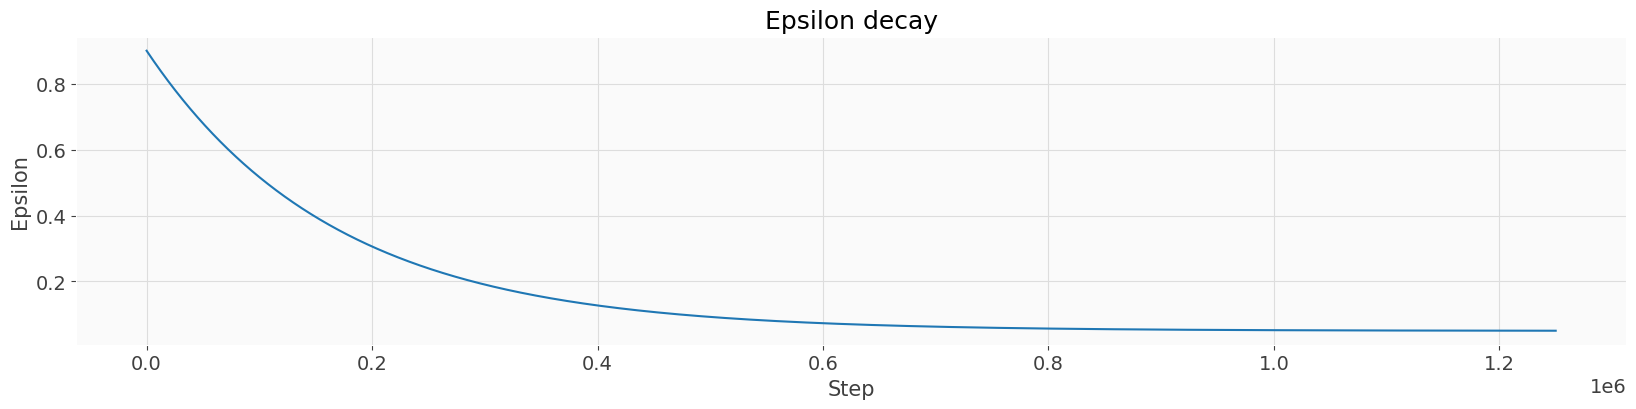

In [3]:
# epilson decay graph
# num episodes times avg steps per episode
num_steps = 50000 * 25
eps_start = 0.9
eps_end = 0.05
eps_decay = num_steps / 7.5
steps = np.arange(num_steps)
epsilon = eps_end + (eps_start - eps_end) * np.exp(-1 * steps / eps_decay)
plt.rcParams["figure.figsize"] = (20, 4)
plt.plot(steps, epsilon)
plt.title('Epsilon decay')
plt.xlabel('Step')
plt.ylabel('Epsilon')
plt.show()

En el método `act` del agente DQN, a continuación, se implementa esta estrategia.

Si el valor de la muestra es superior al umbral de epsilon, se aproximará la mejor acción dada la última observación del entorno (explotación de las acciones aprendidas).

En caso contrario, se elegirá una acción (exploración) de entre las acciones válidas de manera uniforme.


In [4]:
class DQNAgent:
    def __init__(self, net: nn.Module, params: ParamsAgent, device: torch.device, load_model_path: str | None = None) -> None:
        self.net = net
        self.params = params
        self.device = device
        self.eps_threshold = 0.

    def act(self, state: np.ndarray, valid_actions: List[int], num_steps: int, enforce_valid_action: bool) -> int:
        """ 
        Either predicts an action (exploitation) or chooses a random action (exploration) depending on the epsilon threshold.

        Args:
            - `state`: the state in which to predict the action.
            - `valid_actions`: set of valid actions.
            - `num_steps`: current total number of steps taken during training.
            - `enforce_valid_action`: whether to enforce that the action is valid or not.

        Returns:
            - The chosen action.
        """
        self.eps_threshold = self.params['epsilon']['end'] + (self.params['epsilon']['start'] - self.params['epsilon']['end']) \
            * math.exp(-1. * num_steps / self.params['epsilon']['decay'])
        if random.random() > self.eps_threshold:
            # exploit learnt actions while not enforcing it is valid
            return self.exploit(state, valid_actions, enforce_valid_action)

        else:
            # explore actions
            return np.random.choice(valid_actions)

    @torch.no_grad()
    def exploit(self, state: np.ndarray, valid_actions: List[int], enforce_valid_action: bool) -> int:
        """ 
        Predicts an action (exploitation). If `enforce_valid_action` is True, it enforces that the action
        is in `valid_actions` (action space).

        Args:
            - `state`: the state in which to predict the action.
            - `valid_actions`: Set of valid actions or None.
            - `enforce_valid_action`: if True, it enforces that the action is valid.

        Returns:
            - The chosen action.
        """
        tensor_state = torch.tensor(
            data=get_two_channels(np.expand_dims(state, 0)),
            dtype=torch.float,
            device=self.device
        )
        output = self.net(tensor_state, 'policy').squeeze().cpu().numpy()
        if enforce_valid_action:
            # only outputs in valid actions can be considered
            all_actions = np.arange(self.params['out_features'])
            valid_actions_mask = [
                action in valid_actions for action in all_actions]
            return int(np.argmax(output == np.max(output[valid_actions_mask]), keepdims=False))

        else:
            return int(np.argmax(output, keepdims=False))

> Se da la opción, mediante `enforce_valid_action`, de asegurar que la acción elegida sea válida, o de que se inste al modelo a que aprenda qué columnas del tablero pueden optar en cada turno a una nueva ficha, es decir, a que aprenda esta regla del juego.

Los datos que se utilizan para entrenar el agente se generan desde cero durante cada entrenamiento. Estos datos se almacenan en un objeto de clase [`ExperienceReplay`](/replay.py "Experience replay") y se muestrean aleatoriamente con el objetivo de optimizar una estrategia o plan de acción (_policy_).

Las observaciones en cada iteración se adjuntan como tuplas nombradas (itertools' `named_tuple`) a una lista secuencia (`deque`, o cola de doble extremo) con capacidad limitada, donde las observaciones se pueden insertar y eliminar desde ambos extremos, creando así una experiencia de juego.

Cada observación incluye un estado (el tablero del juego en ese preciso instante), una acción (el índice de la columna que ha sido elegida), un siguiente estado (el tablero del juego tras considerar la última acción, o `None` si es un estado final, es decir si se ha tomado una acción ganadora) y una recompensa.

Una vez se hayan obtenido y memorizado más observaciones que el número de _batch_size_ que utilicemos, procederemos a optimizar el modelo.

En nuestro ejemplo, solamente se optimiza una vez por episodio dado que los valores de las transiciones dependerán en algunas ocasiones de transiciones anteriores.

Por ejemplo, cuando un jugador gana la partida obtiene una recompensa positiva, por lo que para la transición del estado en esta iteración se genera una tupla de la siguiente manera:

`transition = Transition(state, action, None, reward)`

La transición consistiría en el estado en `t`, la acción tomada, el estado en `t+1` (al ser un estado final se le asigna `None`) y la recompensa obtenida.

Lo que sucede es que durante la generación de la observación en la iteración anterior, no sabíamos todavía de este desenlace y por lo tanto la recompensa no fue negativa por haber perdido el juego.

Por esta razón, una vez termina cada partida del entrenamiento se resuelve esta relación de recompensas para guardarlas posteriormente en memoria.

Por lo tanto, el transición en `t-1` de la transición de arriba sería:

`transition_t-1 = Transition(state, action, next_state, reward + env.params['rewards']['loss'])`

> Se suma a la recompensa asignada y no se asigna directamente la recompensa de pérdida dado que es posible configurar una recompensa por prolongación en el juego como hiperparámetro.

El proceso de optimización se muestra a continuación:


In [5]:
class DQNAgent(DQNAgent):
    def __init__(self, net: nn.Module, params: ParamsAgent, device: torch.device, load_model_path: str | None = None) -> None:
        super().__init__(net, params, device, load_model_path)
        self.criterion = getattr(
            torch.nn, params['criterion']['name'])(**params['criterion']['config'])
        self.memory = ExperienceReplay(maxlen=params['memory__maxlen'],
                                       batch_size=params['batch_size'])

    def optimize(self) -> float:
        """ 
        Performs one step of the optimization on the policy network.

        Returns:
            - The computed loss.
        """
        transitions = self.memory.recall()
        batch = Transition(*zip(*transitions))
        # (batch_size x 2 x observation_space x action_space)
        state_batch = torch.tensor(
            data=get_two_channels(np.stack(batch.state)),
            device=self.device,
            dtype=torch.float
        )
        # (batch_size x 1)
        action_batch = torch.tensor(
            data=np.stack(batch.action),
            device=self.device,
            dtype=torch.long
        ).unsqueeze(1)
        # compute current Q values
        # (batch_size, 1)
        q_pred = self.net(state_batch, 'policy').gather(
            dim=1,
            index=action_batch)
        # compute expected Q values
        # (batch_size, 1)
        q_next = self._get_expected_state_action_values(
            batch.next_state, batch.reward)
        # compute loss
        loss = self.criterion(q_pred, q_next)
        # set gradients to none instead of zero (reduces the number of memory operations)
        self.optimizer.zero_grad(set_to_none=True)
        # compute gradients
        loss.backward()
        # in-place gradient clipping
        if self.params['clip_grads'] is not None:
            getattr(torch.nn.utils,
                    self.params['clip_grads']['name'])(self.net.policy.parameters(), **self.params['clip_grads']['config'])
        # optimize the model
        self.optimizer.step()
        return loss.item()

    @torch.no_grad()
    def _get_expected_state_action_values(self, next_state: tuple, rewards: tuple) -> torch.Tensor:
        """
        Computes expected Q values.

        Args:
            - `next_states`: tuple of next state numpy arrays.
            - `rewards`: tensor with the stacked rewards.
            - `batch_size`: the size of the batch.
        """
        # (batch_size)
        reward_batch = torch.tensor(
            data=np.stack(rewards),
            device=self.device,
            dtype=torch.float
        )
        # (batch_size)
        q_next = torch.zeros(
            size=reward_batch.size(),
            device=self.device
        )
        # (batch_size)
        non_final_mask = torch.tensor(
            data=tuple(map(lambda s: s is not None, next_state)),
            device=self.device,
            dtype=torch.bool
        )
        # (batch_size - final_states, 2, observation_space, action_space)
        non_final_next_states = torch.tensor(
            data=get_two_channels(np.concatenate(
                [np.expand_dims(s, 0) for s in next_state if s is not None])),
            device=self.device,
            dtype=torch.float
        )

        if self.params['double']:
            # use both policy and target to approximate the q values of the next states
            # (batch_size - final_states, action_space)
            output = self.net(non_final_next_states, 'policy')
            # (batch_size, 1)
            best_actions = output.argmax(1).unsqueeze(1)
            # (batch_size, 1)
            q_pred = self.net(non_final_next_states, 'target').gather(
                dim=1, index=best_actions)
            # use mask to keep q values for non final states zero
            # (batch_size)
            q_next[non_final_mask] = q_pred.squeeze(1)

        else:
            # get the q values of the non-final next states using the target network
            # (batch_size - final_states, action_space)
            output = self.net(non_final_next_states, 'target')
            # (batch_size - final_states)
            q_pred = output.max(1)[0]
            # use mask to keep q values for non final states zero
            # (batch_size)
            q_next[non_final_mask] = q_pred
        # apply the discount factor, subtract from the reward and add a dimension
        # (batch_size, 1)
        return (reward_batch - (self.params['gamma'] * q_next)).unsqueeze(1)

En primer lugar, se muestrean en el método `optimize` un número de observaciones en memoria, y se concatenan todos los valores de estado y acción de las observaciones en matrices independientes.

Además, tanto los estados en `t` como en `t+1` obtienen una nueva dimensión dado que se aplica una transformación del tablero mediante la función `get_two_channels``.

> La idea es que por cada tablero con valores 0, 1 o 2 se obtengan dos matrices con valores binarios, una para cada jugador.
>
> Estas dos matrices serán los dos canales de entrada por observación que obtendrá nuestra [red neuronal convolucional](#modelado "Modelado").

Después se genera una matriz lógica que se utilizará como máscara para asignar los valores Q a los estados que no sean finales, mientras que los finales tendrán un valor de cero.

En el caso de que se utilice un agente DQN, se utiliza solamente el modelo de _target_ para obtener los valores de Q, obteniendo simplemente los valores de máxima magnitud de entre todas las acciones.

Mientras que con un agente DDQN, para intentar solventar una posible sobreestimación de estos valores, se utilizan tanto nuestro modelo _policy_ como nuestro modelo "fijo" _target_ para obtener los valores de diferencia temporal de Q a los que nos queremos aproximar.

Posteriormente, se calcula la ganancia a largo plazo que se puede anticipar. Para ello, se aplica un factor de descuento _gamma_ y se resta de la recompensa para esa transición (en lugar de sumarse como en la [ecuación de Bellman](https://es.wikipedia.org/wiki/Ecuaci%C3%B3n_de_Bellman) tal y como se sugiere en este [cuaderno de Kaggle](https://www.kaggle.com/code/agade09/connectx-with-minimax-dqn)).

De esta manera adaptamos nuestra optimización para el aprendizaje de ambas estrategias al juego alterno de suma cero que nos ocupa.

Es en este momento cuando se optimizan los parámetros de nuestra _policy_. Para ello se calcula la pérdida (en nuestro caso se utiliza el criterio `torch.nn.HuberLoss`) para minimizar el error de la diferencia temporal δ, se asignan valores nulos a los gradientes para posteriormente ser computados mediante _backpropagation_, se aplica un clipeado de los mismos en caso de que así se haya configurado el entrenamiento y se actualizan los parámetros en base al gradiente calculado.

Una vez optimizados los parámetros de la _policy_ durante el entrenamiento, se plantea si actualizar los parámetros de nuestro _target_. Para ello se implementan dos estrategias: _soft update_ y _hard update_.

La primera actualizará los parámetros de forma gradual en cada episodio solamente obteniendo una parte porcentual de los parámetros de _policy_ en base al valor _TAU_ considerado como hiperparámetro en el entrenamiento.

> Por ejemplo, si _TAU_ es 0.001, _target_ pasará a utilizar el 0.1% de los parámetros de _policy_ y mantendrá el 99,9%.

Por el contrario, mediante _hard update_ se copiarán todos los parámetros de golpe si se alcanza un número de iteraciones a configurar.


In [6]:
class DQNAgent(DQNAgent):
    def __init__(self, net: nn.Module, params: ParamsAgent, device: torch.device, load_model_path: str | None = None) -> None:
        super().__init__(net, params, device, load_model_path)

    def update_target(self, episode: int) -> None:
        """ 
        Updates the target model either softly or hardly.

        Args:
            - `episode`: current episode of the training.
        """
        if self.params['target_update']['mode'] == 'soft':
            # soft update of the target network's weights
            target_net_state_dict = self.net.target.state_dict()
            policy_net_state_dict = self.net.policy.state_dict()

            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * \
                    self.params['target_update']['config']['tau'] + target_net_state_dict[key] * \
                    (1-self.params['target_update']['config']['tau'])

            self.net.target.load_state_dict(target_net_state_dict)

        else:
            # hard update of the target network's weights
            if episode + 1 % self.params['target_update']['config']['period'] == 0:
                self.net.target.load_state_dict(self.net.policy.state_dict())

Por último, se implementan tres métodos para guardar transiciones en memoria, guardar parámetros actuales de _policy_ para configurar _checkpoints_ durante el entrenamiento y para cargar los pesos de un modelo guardado al principio de un entrenamiento.

> Nótese que el optimizador se instancia una vez se hayan podido cargar los pesos del modelo de uno previamente guardado.


In [7]:
class DQNAgent(DQNAgent):
    def __init__(self, net: nn.Module, params: ParamsAgent, device: torch.device, load_model_path: str | None = None) -> None:
        super().__init__(net, params, device, load_model_path)
        if load_model_path is not None:
            self._load(load_model_path)
        self.optimizer = getattr(torch.optim, params['optimizer']['name'])(
            self.net.policy.parameters(), **params['optimizer']['config'])

    def cache(self, state: np.ndarray, action: int, next_state: np.ndarray | None, reward: float) -> None:
        """
        Pushes a transition into memory.

        Args:
            - `state`: the state at time t.
            - `action`: the chosen action.
            - `next_state`:  the state at time t + 1.
            - `reward`: the reward after performing the action.
        """
        self.memory.push(state, action, next_state, reward)

    def save(self, checkpoints_dir_path: str, model_id: str, current_step: int) -> None:
        """
        Saves the model `model_id`'s `state_dict` and the current `eps_threshold` in `checkpoints_dir_path`.

        Args:
            - `checkpoints_dir_path`: the directory where to save the model.
            - `model_id`:  the id of the model.
            - `current_step`: the current step in the training.
        """
        Path(checkpoints_dir_path).mkdir(
            parents=True,
            exist_ok=True
        )
        model_path = join(checkpoints_dir_path, f'{model_id}.chkpt')
        checkpoint = {
            "state_dict": self.net.state_dict(),
            "eps_threshold": self.eps_threshold
        }
        torch.save(
            obj=checkpoint,
            f=model_path
        )
        print(
            f"Model saved to {model_path} at step {current_step} with epsilon threshold {np.round(self.eps_threshold, 4)}")

    def _load(self, load_model_path: str):
        """
        Loads the model in `load_model_path`, i.e., sets its `state_dict` to `self.net` and updates `eps_threshold`.

        Args:
            - `load_model_path`: the path to the model that is to be loaded.
        """
        checkpoint_path = Path(load_model_path)
        if not checkpoint_path.exists():
            raise ValueError("The checkpoint path does not exist.")
        check = torch.load(f=checkpoint_path, map_location=self.device)
        eps_threshold = check.get('eps_threshold')
        state_dict = check.get('state_dict')
        self.eps_threshold = eps_threshold
        self.net.load_state_dict(state_dict=state_dict)
        print(
            f"Model at {checkpoint_path} with an epsilon threshold of {eps_threshold} has been loaded")

#### Modelado

El modelo elegido para aprender el juego de Conecta Cuatro consiste de dos capas convolucionales con activación ReLU y dos capas completamente conectadas (la primera también con activación ReLU) en la salida.

En el mismo objeto de clase `ConnectFourNet` se instancian dos módulos, uno para _policy_ y otro para _target_. Este último se copia del primero una vez se hayan inicializado sus parámetros (pesos y sesgo).

> De esta manera podemos guardar los parámetros de ambos modelos durante el entrenamiento en el mismo diccionario de estados.

In [8]:
class ConnectFourNet(Module):
    def __init__(self, out_features: int):
        super(ConnectFourNet, self).__init__()

        self.policy = nn.Sequential(
            # (N, Cin, Hin, Win) -> (N, Cout, Hout, Wout)
            nn.Conv2d(
                in_channels=2,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            # (N, Cin, Hin, Win) -> (N, Cout, Hout, Wout)
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            # (N, Cin, Hin, Win) -> (N, Hout)
            nn.Flatten(),
            # (N, Win) -> (N, Hout)
            nn.Linear(
                in_features=672,
                out_features=128
            ),
            nn.ReLU(),
            # (N, Win) -> (N, Hout)
            nn.Linear(
                in_features=128,
                out_features=out_features
            )
        )

        for module in self.modules():
            if isinstance(module, nn.Conv2d) | isinstance(module, nn.Linear):
                if isinstance(module.weight.data, torch.Tensor):
                    nn.init.xavier_uniform_(module.weight.data)
                module.bias.data.zero_

        self.target = copy.deepcopy(self.policy)
        for param in self.target.parameters():
            param.requires_grad = False

    def forward(self, x: torch.Tensor, model: Literal['policy', 'target']):
        if model == 'policy':
            return self.policy(x)

        elif model == 'target':
            return self.target(x)


print(ConnectFourNet(out_features=7))

ConnectFourNet(
  (policy): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=672, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=7, bias=True)
  )
  (target): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=672, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=7, bias=True)
  )
)


In [9]:
ConnectFourNet(out_features=7).layer_summary([512, 2, 6, 7])

Conv2d output shape:          torch.Size([512, 16, 6, 7])
Conv2d output shape:          torch.Size([512, 16, 6, 7])
Flatten output shape:         torch.Size([512, 672])
Linear output shape:          torch.Size([512, 128])
Linear output shape:          torch.Size([512, 7])


## Entrenamiento

Como se ha apuntado previamente, el [`entrenamiento`](/training.py "Funciones utilizades para el entrenamiento") de la política de juego aúna las estrategias de ambos jugadores. Para ello se experimenta con la utilización de los agentes DQN y DDQN.

### DQN

En primer lugar configuramos todos los parámetros no solo del entrenamiento sino también de la evaluación, entorno y agente, y con estos parámetros se instancian el módulo con las redes neuronales, el agente y el entorno.


In [10]:
# parameters
params_env: ParamsEnv = {
    'action_space': 7,
    'observation_space': 6,
    'rewards': {
        'win': 1.,
        'loss': -1.,
        'draw': 0,
        'prolongation': -0.
    }
}

params_eval: ParamsEval = {
    'enforce_valid_action': False,
    'episodes': 100,
    'period': 25
}

params_train: ParamsTrain = {
    'batch_size': 512,
    'checkpoint': {
        'save_every':  20000,
        'save_on_exit': True
    },
    'display_period': 1000,
    'enforce_valid_action': False,
    'episodes': 50000,
    'scheduler': {
        'name': 'MultiStepLR',
        'config': {
            'milestones': [40000],
            'gamma': 0.2
        }
    }
}

params_agent: ParamsAgent = {
    'batch_size': params_train['batch_size'],
    'clip_grads': None,
    #  'clip_grads': {'name': 'clip_grad_norm_',
    #                 'config': {'max_norm': 1.0,
    #                            'norm_type': 2}},
    'criterion': {
        'name': 'HuberLoss',
        'config': {}
    },
    'double': False,
    'epsilon': {
        'start': 0.9,
        'end': 0.05,
        # the higher the more exploration
        # avg num_steps / factor
        'decay': params_train['episodes'] * 25 / 7.5
    },
    'gamma': 0.99,
    'memory__maxlen': params_train['episodes'] * 25,
    'optimizer': {
        'name': 'SGD',
        'config': {
            'lr': 1e-2,
            'momentum': 0.9,
            # 'weight_decay': 0.001
        }
    },
    'target_update': {
        'mode': 'soft',
        'config': {
            'tau': 0.005
        }
    },
    # 'target_update': {
    #     'mode': 'hard',
    #     'config': {
    #         'period': 100
    #     }
    # },
    'out_features': params_env['action_space']
}

# nets
dqn_net = ConnectFourNet(out_features=params_env['action_space']).to(device)

# agent
load_model_path = None
# load_model_path = join('CHECKPOINTS_DIR_PATH'', 'ConnectFourNet_2023-10-10T07:52:28.chkpt')
dqn_agent = DQNAgent(
    net=dqn_net,
    params=params_agent,
    device=device,
    load_model_path=load_model_path
)

# environment
env = ConnectFourEnv(
    params=params_env,
    device=device
)

Una vez instanciadas todas las entidades y parámetros que se necesitan podemos iniciar el entrenamiento del agente para optimizar la _policy_.

La función `train` muestra métricas de iteraciones de manera periódica. Algunos valores corresponderán a medias obtenidas a partir de valores actuales y de iteraciones previas para poder reconocer las tendencias durante el entrenamiento.

En cada episodio se evalúa el modelo de _policy_ jugando contra un agente _random_.


In [11]:
# train policy
dqn_args = train(
    agent=dqn_agent,
    env=env,
    params_train=params_train,
    params_eval=params_eval,
    checkpoints_dir_path=CHECKPOINTS_DIR_PATH,
    device=device
)

Training policy in ConnectFourNet.
 Episode     Step   Train rewards (avg)  steps (avg)   running loss (avg)  Eval reward (mean std)  win rate(%)   Eps      LR     Time    
   999      20467       0.0 (-0.04)       19 (19.84)    0.0464 (0.0459)         0.46  0.7269          60.0     0.8018   0.01    0.02s   
   1999     40734       0.0 (-0.04)       18 (17.0)     0.0502 (0.0453)         0.65  0.5723          70.0     0.7157   0.01    0.02s   
   2999     60847       -1.0 (-0.08)      32 (23.28)     0.055 (0.048)          0.77  0.4659          79.0      0.64    0.01    0.03s   
   3999     80435        0.0 (0.0)        23 (21.64)    0.0513 (0.0467)         0.79  0.4312          80.0     0.5746   0.01    0.03s   
   4999     100228      0.0 (-0.08)       28 (20.48)    0.0469 (0.0487)         0.81  0.4403          83.0     0.5159   0.01    0.02s   
   5999     119836      0.0 (-0.04)       12 (18.96)    0.0389 (0.0475)         0.93  0.2551          93.0     0.4641   0.01    0.04s   
   69

Las recompensas para cada episodio suelen ser cero dado que se suma la puntuación ganadora a la perdedora (-1 + 1), en cambio la media que aparece entre paréntesis en ocasiones es diferente a cero. Esto es debido a que en algunos episodios el modelo elige una acción que no es válida y obtiene una recompensa como si hubiese perdido el juego, pero no se le asigna una recompensa ganadora al otro jugador puesto que no se da la transición siguiente.

Como podemos ver, esta media tiende a disminuir, es decir, el modelo tiende a cometer menos errores a la hora de elegir acciones que sean legales.


Model training and evaluation figure saved to exports/figures/ConnectFourNet_2023_10_29_T_20_28_55.png


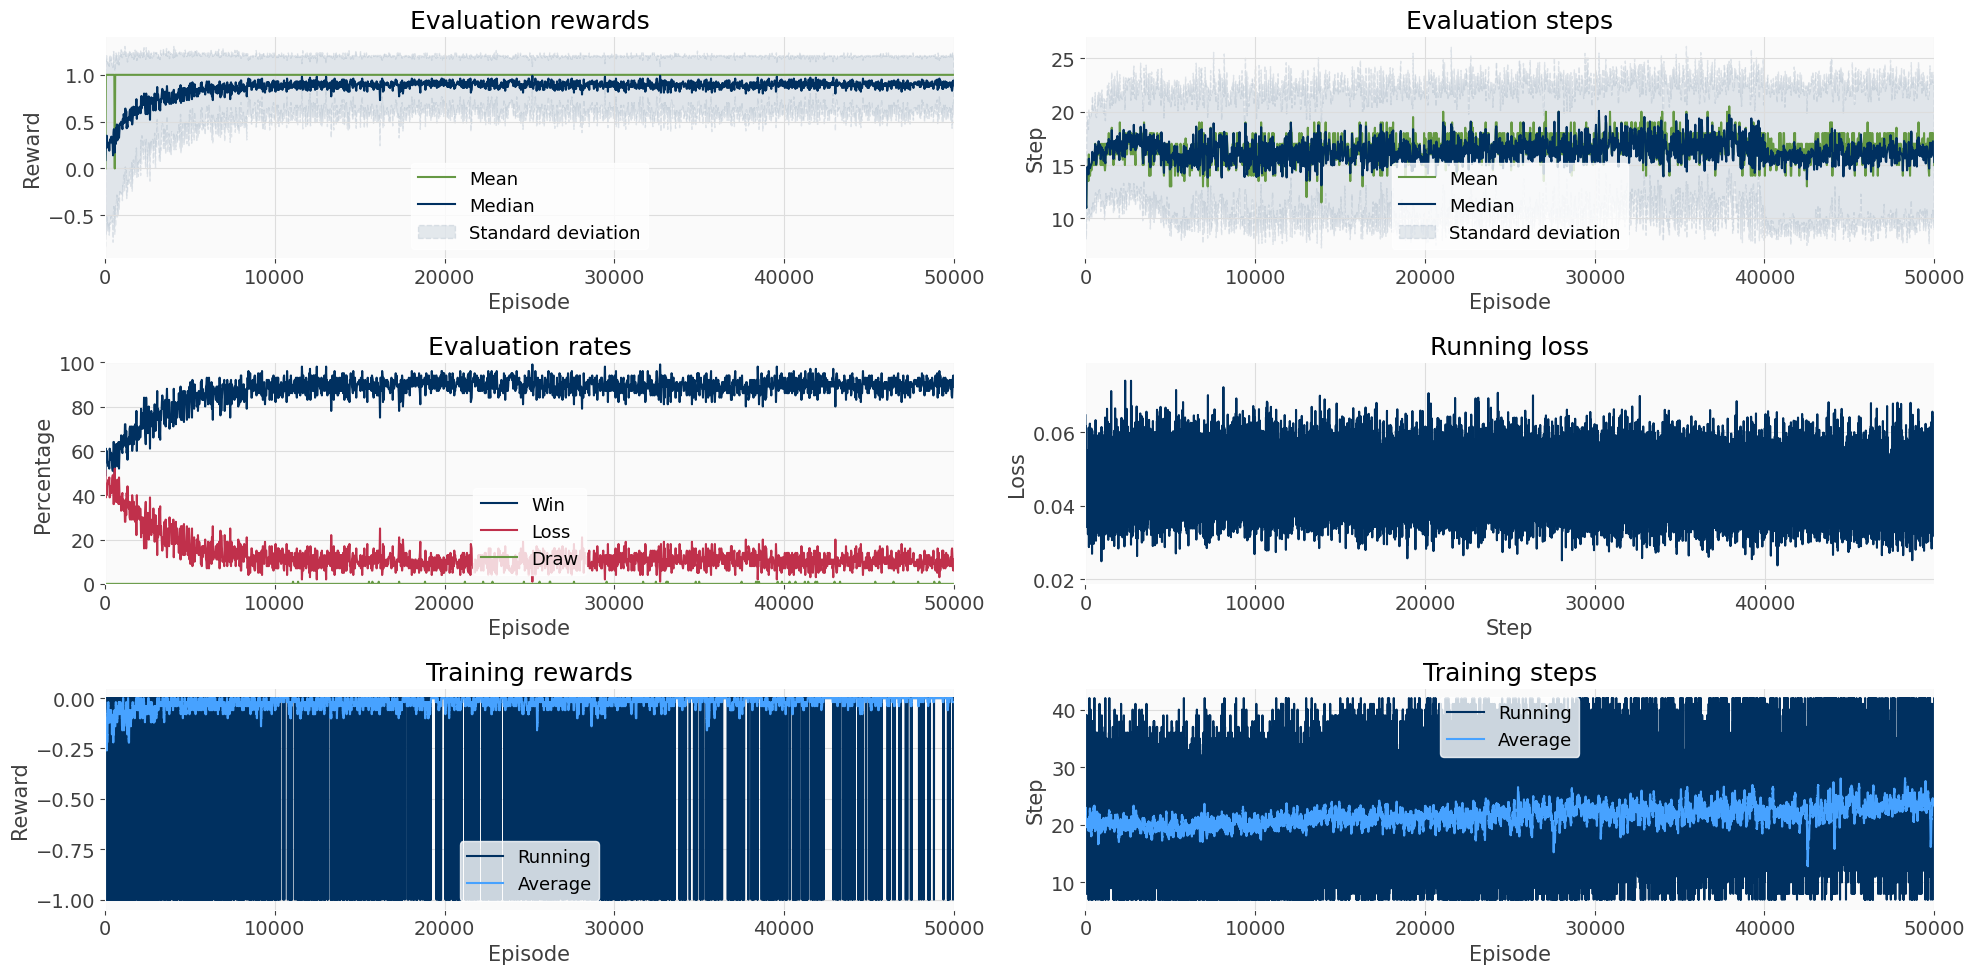

In [12]:
# plot training results
plot(
    *dqn_args,
    figures_dir_path=FIGURES_DIR_PATH,
)

En los gráficos anteriores podemos comprobar lo que comentamos previamente. Además, se observa cómo la cantidad de iteraciones tiende a aumentar ligeramente durante el entrenamiento y la evaluación.

Cabía esperar que en el entrenamiento se alargasen las partidas dado que a medida que el modelo aprende sigue jugando contra sí mismo.

En cambio, en lo que respecta a la evaluación, y considerando que el modelo juega contra una toma de decisiones aleatorias, cabría esperar que, pese a que hay una ligera reducción en la cantidad de turnos que necesita para ganar con el paso de las iteraciones, la reducción fuese mayor.

De cualquier manera, el modelo tiende a ganar casi la totalidad de las partidas, como podemos ver en _Evaluation rates_.

> Una opción a probar para incentivar al modelo a intentar que las partidas sean más cortas podría ser asignar una recompensa negativa a `params_env['rewards']['prolongation']`.

Por otra parte, al estar aprendiendo una estrategia o política de acción para un escenario no estacionario, el cual depende de acciones puntuales, solamente se considera el gráfico de _Running loss_ para la elección del hiperparámetro del tamaño del lote de entrenamiento (`batch_size`) y para comprobar que los gradientes ni aumentan ni disminuyen considerable o exponencialmente (_exploding gradients_ y _vanishing gradients_).

A continuación podemos comprobar cómo actúa nuestra _policy_ con ejemplos de posibles tableros legales en situaciones clave del juego, solamente por motivos de ilustración.

En primer lugar vemos si es capaz de completar algunas líneas de cuatro para ganar un juego.


In [13]:
# set eval mode
dqn_net.policy.eval()
titles = [
    "Horizontal P2", "Horizontal P1", "Vertical P2", "Vertical P1", "Diagonal P2",
    "Diagonal P1", "Anti diagonal P2", "Anti diagonal P1"
]

finishes_boards = [board for i, (board, _) in enumerate(
    finishes_boards_solutions) if i % 2 != 0]
html = get_html(
    policy=dqn_net.policy,
    observations=finishes_boards,
    titles=titles,
    device=device
)
display(HTML(html))

,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,,,,O
4,,,,,,O,O
5,,,,X,X,X,O
,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,


Podemos ver como este modelo es capaz de elegir acciones para ganar el juego ya sea horizontal, vertical, diagonal o anti diagonalmente, aunque no para ambos jugadores en todas las modalidades de líneas, sí para ambos jugadores en distintas modalidades.

De manera similar sucede cuando a nuestro aproximador se le presenta la ocasión de bloquear líneas de cuatro fichas consecutivas para ganar un juego justo en el turno anterior de que puedan suceder estas transiciones ganadoras.


In [14]:
blocks_boards = [board for i, (board, _) in enumerate(
    blocks_boards_solutions) if i % 2 != 0]
html = get_html(
    policy=dqn_net.policy,
    observations=blocks_boards,
    titles=titles,
    device=device
)
display(HTML(html))

,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,,,,
4,,,,,,,X
5,,,,O,O,O,X
,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,


### DDQN

Por último se ha procedido al entrenamiento de un agente DQN doble en el mismo ejercicio. Se han utilizado hiperparámetros de entrenamiento similares.

In [15]:
# net
ddqn_net = ConnectFourNet(out_features=params_env['action_space']).to(device)

# agent
params_agent['double'] = True
ddqn_agent = DQNAgent(
    net=ddqn_net,
    params=params_agent,
    device=device,
    load_model_path=load_model_path
)

# train policy
ddqn_args = train(
    agent=ddqn_agent,
    env=env,
    params_train=params_train,
    params_eval=params_eval,
    checkpoints_dir_path=CHECKPOINTS_DIR_PATH,
    device=device
)

Training policy in ConnectFourNet.
 Episode     Step   Train rewards (avg)  steps (avg)   running loss (avg)  Eval reward (mean std)  win rate(%)   Eps      LR     Time    
   999      20530       -1.0 (-0.08)      15 (20.2)     0.0469 (0.0457)         0.44  0.7658          61.0     0.8015   0.01    0.02s   
   1999     40849       0.0 (-0.08)       23 (21.96)     0.0536 (0.044)          0.63  0.627          71.0     0.7152   0.01    0.04s   
   2999     60557       0.0 (-0.08)       18 (19.4)      0.041 (0.0459)         0.77  0.4659          79.0     0.641    0.01    0.03s   
   3999     79788        0.0 (0.0)        24 (19.88)     0.0379 (0.047)         0.74  0.5024          77.0     0.5766   0.01    0.03s   
   4999     99764        0.0 (0.0)        27 (21.72)    0.0397 (0.0461)         0.77  0.4659          79.0     0.5172   0.01    0.04s   
   5999     118905       0.0 (0.0)        18 (18.0)     0.0575 (0.0478)         0.82  0.3842          82.0     0.4665   0.01    0.04s   
   69

Como podemos ver a continuación, los resultados del entrenamiento son similares al agente DQN, en cambio, los resultados del modelo frente a una toma de decisiones aleatoria son ligeramente peores.

Model training and evaluation figure saved to exports/figures/ConnectFourNet_2023_10_29_T_21_57_41.png


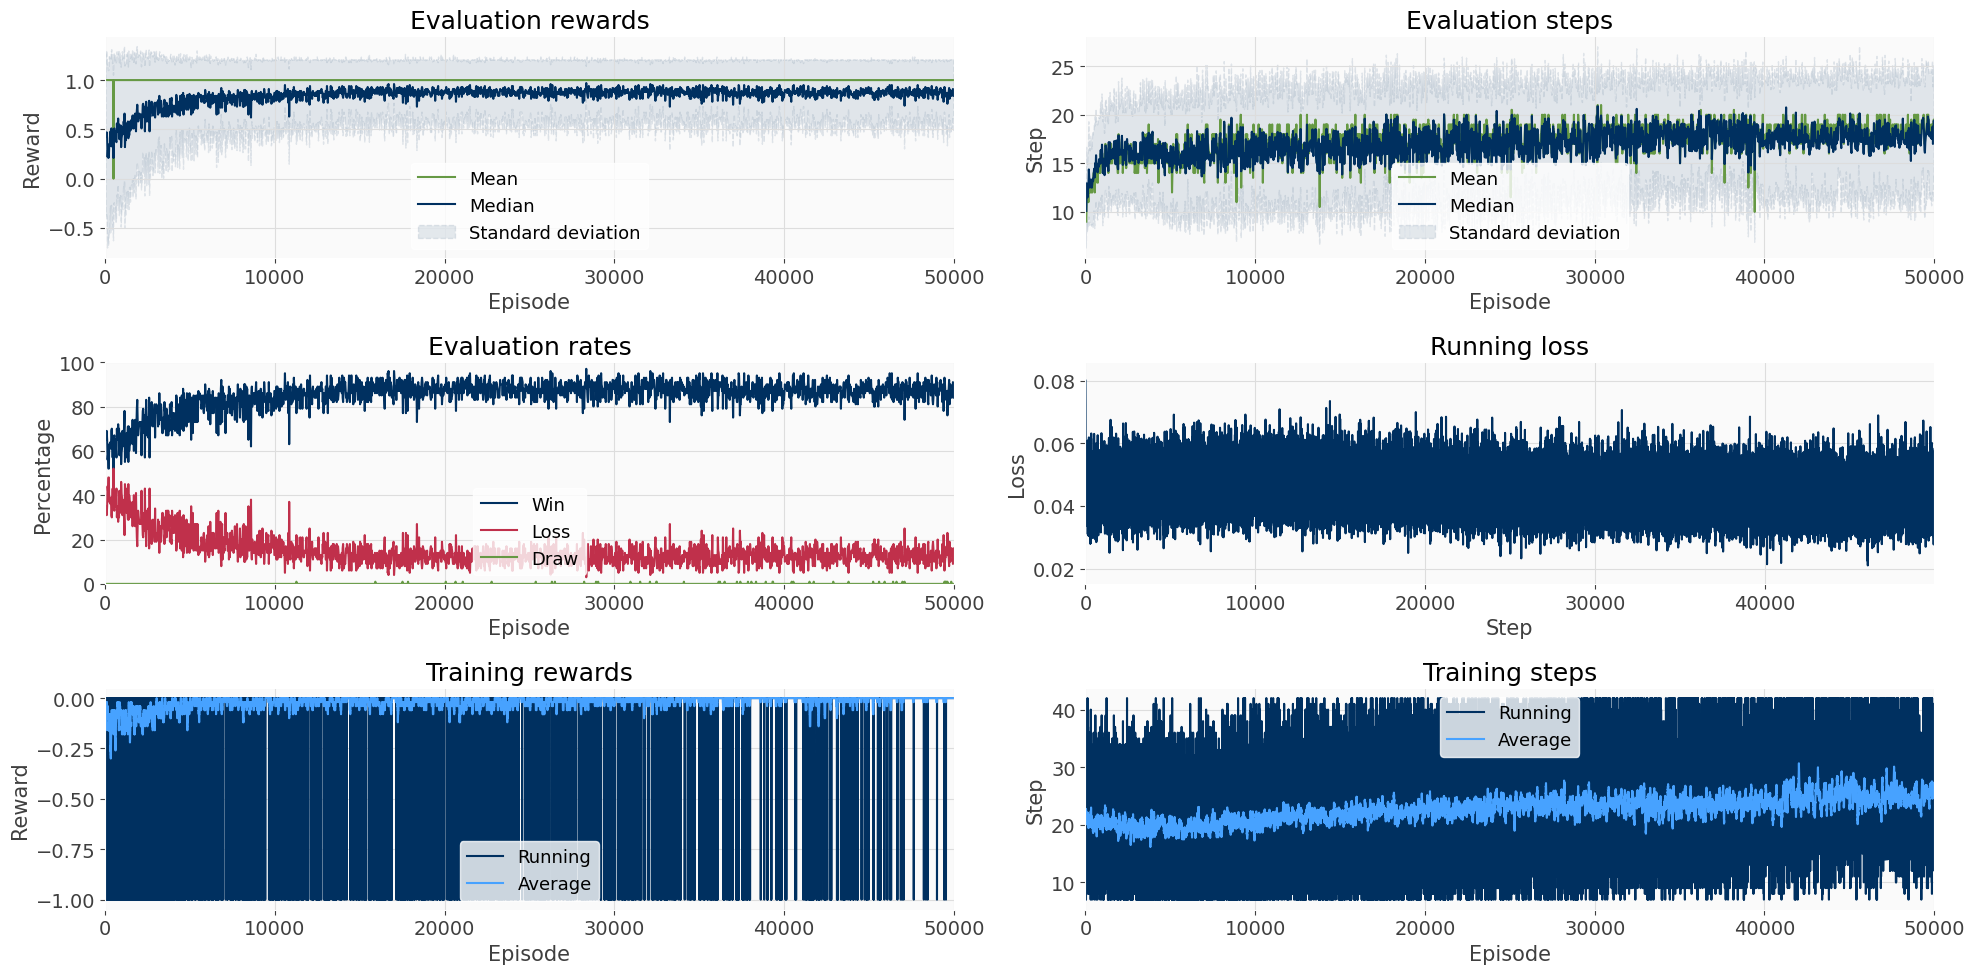

In [16]:
# plot training results
plot(
    *ddqn_args,
    figures_dir_path=FIGURES_DIR_PATH,
)

De nuevo, solo por motivos de ilustración, le planteamos a nuestro modelo unas observaciones de escenarios clave en el juego para tener una idea de cómo se desenvuelve.

In [17]:
# set eval mode
ddqn_net.policy.eval()
html = get_html(
    policy=ddqn_net.policy,
    observations=finishes_boards,
    titles=titles,
    device=device
)
display(HTML(html))

,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,,,,O
4,,,,,,O,O
5,,,,X,X,X,O
,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,


Como vemos, sigue siendo capaz de resolver la mejor acción en la mayoría de tableros tanto para ganar la partida como para bloquear al jugador contrario a que la gane:

In [18]:
html = get_html(
    policy=ddqn_net.policy,
    observations=blocks_boards,
    titles=titles,
    device=device
)
display(HTML(html))

,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,,,,
4,,,,,,,X
5,,,,O,O,O,X
,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,


Cabe la posibilidad que los modelos no rindan tan bien en partidas prolongadas del juego dado que durante el entrenamiento reciben más observaciones de tableros con menos fichas.

Hay muchos parámetros del entrenamiento a modificar e intentar una mejor generalización del modelo. Por ejemplo, las recompensas, la tasa de decadencia de epsilon, el tamaño del lote de observaciones, la capacidad de la memoria, la tasa de aprendizaje o incluso implementar otra arquitectura de red neuronal o modificar y/o incluir capas convolucionales o las completamente conectadas.

Además, se pueden implementar algoritmos de aprendizaje por refuerzo más modernos como la optimización de políticas proximales (PPO), o hacer uso de una memoria de observaciones con muestreado priorizado.

La librería [TorchRL](https://github.com/pytorch/rl "TorchRL"), que es una librería de aprendizaje por refuerzo para PyTorch, implementa estas y otras muchas opciones.

## Exportación

Como se apunta en la introducción de este cuaderno de Jupyter, este modelo se utiliza en una aplicación web descentralizada de conocimiento cero.

Por esta razón, se hace uso del módulo `torch.onnx` para convertir el gráfico de cálculo nativo de PyTorch a un gráfico [ONNX](https://onnx.ai "Página web de ONNX") y así mediante la librería de Javascript ONNX Runtime Web se pueda desplegar este modelo de aprendizaje automático en nuestra aplicación web.


In [19]:
# export onnx version of the policy trained by the DDQN
_, _, _, model_id = dqn_args
export_onnx(
    policy=dqn_agent.net.policy,
    policies_dir_path=POLICIES_DIR_PATH,
    model_id=model_id,
    device=device
)

Model in ONNX format saved to exports/policies/ConnectFourNet_2023_10_29_T_20_28_55.onnx
